# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In today's business world, keeping customers engaged and preventing them from leaving is very important. Predictive analytics is an important tool that helps businesses predict what customers can do next. By using this information, companies can offer special deals or loyalty programs to keep customers happy and loyal. With so much data available nowadays, businesses are relying more and more on data science to make smart decisions and to brow business successfully.

In [1]:
#This step is to import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, split, stddev, udf, countDistinct, sum as spark_sum, when, expr
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql.functions import from_unixtime, datediff
from pyspark.sql.window import Window

In [2]:
# This step is to create a Spark session
spark = SparkSession.builder.master("local").appName("Spark - Capstone Project").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#This step is to fetch sparkify event data
sparkify_df = spark.read.json('mini_sparkify_event_data.json')

In [4]:
#This step is to get rows and column count of Sparkify event dataset
print("Total number of rows in Sparkify event dataframe are:", sparkify_df.count())
print("Total number of columns in Sparkify event dataframe are:", len(sparkify_df.columns))

Total number of rows in Sparkify event dataframe are: 286500
Total number of columns in Sparkify event dataframe are: 18


In [5]:
#This step is to print schema of sparkify event dataset
sparkify_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#This step is to get descriptive statistics of userid
sparkify_df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [7]:
#This step is to get descriptive statistics of sessionid
sparkify_df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [8]:
#This step is to get missig values of sparkify_df columns

missing_val = sparkify_df.select(
    [
        spark_sum(col(c).isNull().cast("int")).alias(c)
        for c in sparkify_df.columns
    ]
)

missing_val.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [9]:
# This step is to check empty/blank values in UserId column
empty_values_userId = sparkify_df.filter(col('userId') == "").count()
print(empty_values_userId)

8346


In [10]:
# This step is to check empty/blank values in SessionId column
empty_values_sessionId = sparkify_df.filter(col('sessionId') == "").count()
print(empty_values_sessionId)

0


In [11]:
# This step is to remove rows from sparkify_df where UserId column has empty/blank values
sparkify_df_cln = sparkify_df.filter(sparkify_df['userId']!='')

Have removed the data where UserId is missing, Let's check if there are any missing values in UserId or not.

In [12]:
# This step is to get missig values of sparkify_df columns

missing_val = sparkify_df_cln.select(
    [
        spark_sum(col(c).isNull().cast("int")).alias(c)
        for c in sparkify_df_cln.columns
    ]
)

missing_val.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [13]:
# As firstName and lastName columns are not relevant for the analysis, so dropping theses two columns from dataframe
sparkify_df_cln = sparkify_df_cln.drop('firstName', 'lastName')

FirsName and LastName columns have been deleted as it's no longer relevant for analysis purposes.

In [14]:
# This step is to check if FirstName and LastName have been dropped properly
sparkify_df_cln.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [15]:
# This step is to get missig values of sparkify_df columns
missing_val = sparkify_df_cln.select(
    [
        spark_sum(col(c).isNull().cast("int")).alias(c)
        for c in sparkify_df_cln.columns
    ]
)

missing_val.show()

+------+----+------+-------------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|gender|itemInSession|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+------+-------------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|     0|            0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+------+-------------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



Now that we've cleaned most of the variables, it's worth noting that some variables like artist, length, and song still contain null values. While we could simply drop these variables, there's a risk of losing valuable information. Therefore, let's retain these variables and explore their impact further. 

In [16]:
# This step is to get non missig values of sparkify_df_cln columns

non_missing_val = sparkify_df_cln.select(
    [
        spark_sum(col(c).isNotNull().cast("int")).alias(c)
        for c in sparkify_df_cln.columns
    ]
)

non_missing_val.show()

+------+------+------+-------------+------+------+--------+------+------+------------+---------+------+------+------+---------+------+
|artist|  auth|gender|itemInSession|length| level|location|method|  page|registration|sessionId|  song|status|    ts|userAgent|userId|
+------+------+------+-------------+------+------+--------+------+------+------------+---------+------+------+------+---------+------+
|228108|278154|278154|       278154|228108|278154|  278154|278154|278154|      278154|   278154|228108|278154|278154|   278154|278154|
+------+------+------+-------------+------+------+--------+------+------+------------+---------+------+------+------+---------+------+



Variables Artist, length and Song have same number of not null records, it looks like these are users which interacted but have not played any song.

Let's transform ts and registration variables into readable datetime format as current format is Unix based. Two new variables named dateandtime and registration_dateandtime will be created.

In [17]:
# This step is to create dateandtime variable from ts.
sparkify_df_cleaned = sparkify_df_cln.withColumn("dateandtime", from_unixtime(sparkify_df_cln["ts"] / 1000))

In [18]:
# This step is to see dateandtime variable's statistics
sparkify_df_cleaned.describe("dateandtime").show()

+-------+-------------------+
|summary|        dateandtime|
+-------+-------------------+
|  count|             278154|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:01:57|
|    max|2018-12-03 01:11:16|
+-------+-------------------+



In [19]:
# This step is to create registration_dateandtime variable from registration.
sparkify_df_cleaned = sparkify_df_cleaned.withColumn("registration_dateandtime", from_unixtime(sparkify_df_cleaned["registration"] / 1000))

In [20]:
# This step is to see registration_dateandtime variable's statistics
sparkify_df_cleaned.describe("registration_dateandtime").show()

+-------+------------------------+
|summary|registration_dateandtime|
+-------+------------------------+
|  count|                  278154|
|   mean|                    null|
| stddev|                    null|
|    min|     2018-03-18 13:44:35|
|    max|     2018-11-26 15:49:14|
+-------+------------------------+



Let's create a new variable named days_from_registration which will give us an idea of membership time duration.

In [21]:
# This step is to create new variable named days_from_registration
sparkify_df_cleaned = sparkify_df_cleaned.withColumn("days_from_registration", datediff(sparkify_df_cleaned["dateandtime"], sparkify_df_cleaned["registration_dateandtime"]))

Minimum value of days_from registration is -2 so let's see how many such records exists where number of days of registration are in negative.

In [22]:
# This step is to check days_from_registration variable's statistics
sparkify_df_cleaned_chk = sparkify_df_cleaned.filter(sparkify_df_cleaned.days_from_registration < 0)
sparkify_df_cleaned_chk.describe("days_from_registration").show()

+-------+----------------------+
|summary|days_from_registration|
+-------+----------------------+
|  count|                   124|
|   mean|   -1.8064516129032258|
| stddev|   0.39668175187900984|
|    min|                    -2|
|    max|                    -1|
+-------+----------------------+



There are only 124 records where registration has happened after the last date and timestamp.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [23]:
sparkify_df_cleaned.createOrReplaceTempView("Sparkify_cleaned_View")

In [24]:
# Let's check the total count of rows in Sparkify_cleaned_View
spark.sql('''
    select count(*) from Sparkify_cleaned_View
''').show()

+--------+
|count(1)|
+--------+
|  278154|
+--------+



In [25]:
spark.sql('''
    describe Sparkify_cleaned_View
''').show()

+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|              artist|   string|   null|
|                auth|   string|   null|
|              gender|   string|   null|
|       itemInSession|   bigint|   null|
|              length|   double|   null|
|               level|   string|   null|
|            location|   string|   null|
|              method|   string|   null|
|                page|   string|   null|
|        registration|   bigint|   null|
|           sessionId|   bigint|   null|
|                song|   string|   null|
|              status|   bigint|   null|
|                  ts|   bigint|   null|
|           userAgent|   string|   null|
|              userId|   string|   null|
|         dateandtime|   string|   null|
|registration_date...|   string|   null|
|days_from_registr...|      int|   null|
+--------------------+---------+-------+



### Artist
Let's start analysing from the first column artist

In [26]:
spark.sql('''
        SELECT Artist, COUNT(DISTINCT userId) AS usr_cnts
        FROM Sparkify_cleaned_View
        group by Artist
        order by usr_cnts desc
''').show()

+--------------------+--------+
|              Artist|usr_cnts|
+--------------------+--------+
|                null|     224|
|       Kings Of Leon|     199|
|            Coldplay|     189|
|       Dwight Yoakam|     189|
|Florence + The Ma...|     187|
|            BjÃÂ¶rk|     179|
|      The Black Keys|     179|
|       Justin Bieber|     177|
|        Jack Johnson|     173|
|        Taylor Swift|     173|
|     Alliance Ethnik|     172|
|            Harmonia|     172|
|       Guns N' Roses|     170|
|              Eminem|     169|
|               Train|     169|
|         OneRepublic|     168|
|         The Killers|     168|
|           Metallica|     168|
|           Radiohead|     167|
|                Muse|     166|
+--------------------+--------+
only showing top 20 rows



### Auth
Let's start analysing from the column auth

In [27]:
spark.sql('''
        SELECT auth, COUNT(DISTINCT userId) AS usr_cnts
        FROM Sparkify_cleaned_View
        group by auth
        order by usr_cnts desc
''').show()

+---------+--------+
|     auth|usr_cnts|
+---------+--------+
|Logged In|     225|
|Cancelled|      52|
+---------+--------+



### Gender
Let's start analysing from the column gender

In [28]:
spark.sql('''
        SELECT gender, COUNT(DISTINCT userId) AS usr_cnts
        FROM Sparkify_cleaned_View
        group by gender
        order by usr_cnts desc
''').show()

+------+--------+
|gender|usr_cnts|
+------+--------+
|     M|     121|
|     F|     104|
+------+--------+



### itemInSession
Let's start analysing from the column itemInSession

In [29]:
spark.sql('''
        SELECT itemInSession, COUNT(DISTINCT userId) AS usr_cnts
        FROM Sparkify_cleaned_View
        group by itemInSession
        order by usr_cnts desc
''').show()

+-------------+--------+
|itemInSession|usr_cnts|
+-------------+--------+
|            2|     224|
|            4|     224|
|            3|     224|
|            5|     224|
|           13|     223|
|            8|     223|
|            7|     223|
|           14|     223|
|            9|     223|
|            6|     223|
|           12|     222|
|           15|     222|
|            1|     222|
|           16|     222|
|           21|     221|
|           10|     221|
|           20|     221|
|           19|     221|
|           17|     221|
|           11|     220|
+-------------+--------+
only showing top 20 rows



### level
Let's start analysing from the column level

In [30]:
spark.sql('''
        SELECT level, COUNT(DISTINCT userId) AS usr_cnts
        FROM Sparkify_cleaned_View
        group by level
        order by usr_cnts desc
''').show()

+-----+--------+
|level|usr_cnts|
+-----+--------+
| free|     195|
| paid|     165|
+-----+--------+



### Page
Let's start analysing from the column page

In [31]:
spark.sql('''
        SELECT page,COUNT(userId) AS usr_cnts
        FROM Sparkify_cleaned_View
        GROUP BY page
        ORDER BY usr_cnts DESC
''').show()

+--------------------+--------+
|                page|usr_cnts|
+--------------------+--------+
|            NextSong|  228108|
|           Thumbs Up|   12551|
|                Home|   10082|
|     Add to Playlist|    6526|
|          Add Friend|    4277|
|         Roll Advert|    3933|
|              Logout|    3226|
|         Thumbs Down|    2546|
|           Downgrade|    2055|
|            Settings|    1514|
|                Help|    1454|
|             Upgrade|     499|
|               About|     495|
|       Save Settings|     310|
|               Error|     252|
|      Submit Upgrade|     159|
|    Submit Downgrade|      63|
|              Cancel|      52|
|Cancellation Conf...|      52|
+--------------------+--------+



### userAgent
Let's start analysing from the column userAgent

In [32]:
spark.sql('''
        SELECT userAgent, COUNT(userId) AS usr_cnts
        FROM Sparkify_cleaned_View
        GROUP BY userAgent
        ORDER BY usr_cnts DESC
''').show()

+--------------------+--------+
|           userAgent|usr_cnts|
+--------------------+--------+
|"Mozilla/5.0 (Win...|   22751|
|"Mozilla/5.0 (Mac...|   19611|
|"Mozilla/5.0 (Mac...|   18448|
|"Mozilla/5.0 (Mac...|   17348|
|Mozilla/5.0 (Wind...|   16700|
|"Mozilla/5.0 (Win...|   15395|
|"Mozilla/5.0 (Win...|   14598|
|Mozilla/5.0 (Maci...|   10300|
|"Mozilla/5.0 (iPa...|    8912|
|Mozilla/5.0 (comp...|    8624|
|"Mozilla/5.0 (Mac...|    8094|
|"Mozilla/5.0 (Win...|    7923|
|"Mozilla/5.0 (Mac...|    7906|
|"Mozilla/5.0 (Win...|    7624|
|"Mozilla/5.0 (iPh...|    6417|
|Mozilla/5.0 (Wind...|    5989|
|"Mozilla/5.0 (Mac...|    5716|
|"Mozilla/5.0 (Win...|    5238|
|"Mozilla/5.0 (Win...|    4917|
|Mozilla/5.0 (Wind...|    4663|
+--------------------+--------+
only showing top 20 rows



### Define Churn
Once you've done some preliminary analysis, create a column Churn to use as the label for your model. I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the Downgrade events.

In [33]:
spark.sql('''
        SELECT distinct page as Page
        FROM Sparkify_cleaned_View
        GROUP BY page
''').show()

+--------------------+
|                Page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [34]:
sparkify_df_cleaned.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [35]:
# This step is to get count of users who have cancelled
sparkify_df_cleaned.filter(col('page') == 'Cancellation Confirmation').select('userId').dropDuplicates().count()

52

In [36]:
# This step is to get count of users who have downgraded
sparkify_df_cleaned.filter(col('page') == 'Submit Downgrade').select('userId').distinct().count()

49

In [37]:
# This step is to get the count of users that downgrade AND cancel the subscription
sparkify_df_cleaned.filter(col('page') == 'Submit Downgrade').select('userId').distinct().intersect(sparkify_df_cleaned.filter(col('page') == 'Cancellation Confirmation').select('userId').dropDuplicates()).count()

9

There are 52 users who have cancelled their subscription, while 49 users have downgraded. Interestingly, 9 users have taken both actions. Given the relatively low number of churned users, building a reliable statistical model becomes challenging. With such a small sample size, achieving consistent predictions across various data splits, even with different random seeds, presents a considerable challenge

In [38]:
# This function is to add churn label
def add_churn_var(df):

    cancelled_users = (col('page').isin(['Cancellation Confirmation', 'Cancel'])) | (col('auth') == 'Cancelled')
    churn_label = when(cancelled_users, 1).otherwise(0)
    churn_user = df.groupby('userId').agg(spark_sum(churn_label).alias('churn_count'))
    churn_user = churn_user.withColumn('churn', when(col('churn_count') >= 1, 1).otherwise(0))
    churn_df = df.join(churn_user.select('userId', 'churn'), on='userId', how='left')

    return churn_df

In [39]:
# This function is to add churn label in sparkify_df_cleaned
sparkify_df_flg = add_churn_var(sparkify_df_cleaned)

In [40]:
sparkify_df_flg.show()

+------+--------------------+---------+------+-------------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+-------------------+------------------------+----------------------+-----+
|userId|              artist|     auth|gender|itemInSession|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|        dateandtime|registration_dateandtime|days_from_registration|churn|
+------+--------------------+---------+------+-------------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+-------------------+------------------------+----------------------+-----+
|100010|Sleeping With Sirens|Logged In|     F|            0|202.97098| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|       31|Captain Tyin Knot...|   20

In [41]:
# This step is to check the show summary statistics of Churn variable
sparkify_df_flg.describe('churn').show()

+-------+-------------------+
|summary|              churn|
+-------+-------------------+
|  count|             278154|
|   mean|0.16129194618808287|
| stddev|0.36780068056308857|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



# Music Engagement Analysis

Theses steps are mainly to analyse the scenarios where churn has happened.

In [42]:
# This step is to update temporary view
sparkify_df_flg.createOrReplaceTempView("Sparkify_cleaned_View")

In [43]:
# This step is to check variables of Sparkify_cleaned_View
spark.sql('''
    describe Sparkify_cleaned_View
''').show()

+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|              userId|   string|   null|
|              artist|   string|   null|
|                auth|   string|   null|
|              gender|   string|   null|
|       itemInSession|   bigint|   null|
|              length|   double|   null|
|               level|   string|   null|
|            location|   string|   null|
|              method|   string|   null|
|                page|   string|   null|
|        registration|   bigint|   null|
|           sessionId|   bigint|   null|
|                song|   string|   null|
|              status|   bigint|   null|
|                  ts|   bigint|   null|
|           userAgent|   string|   null|
|         dateandtime|   string|   null|
|registration_date...|   string|   null|
|days_from_registr...|      int|   null|
|               churn|      int|   null|
+--------------------+---------+-------+



In [44]:
# This step is to check  userId, auth, level, page, dateandtime where churn has happened
spark.sql('''
          SELECT userId, auth, level, page, dateandtime, churn
          FROM Sparkify_cleaned_View 
          WHERE churn == 1
          and dateandtime is not NULL
          ORDER BY dateandtime DESC
          '''
         ).show(10)

+------+---------+-----+--------------------+-------------------+-----+
|userId|     auth|level|                page|        dateandtime|churn|
+------+---------+-----+--------------------+-------------------+-----+
|100007|Cancelled| paid|Cancellation Conf...|2018-11-29 11:45:09|    1|
|100007|Logged In| paid|              Cancel|2018-11-29 11:45:07|    1|
|100007|Logged In| paid|           Downgrade|2018-11-29 11:45:06|    1|
|100007|Logged In| paid|            NextSong|2018-11-29 11:44:37|    1|
|100007|Logged In| paid|            NextSong|2018-11-29 11:42:58|    1|
|100007|Logged In| paid|         Thumbs Down|2018-11-29 11:39:42|    1|
|100007|Logged In| paid|            NextSong|2018-11-29 11:39:41|    1|
|100007|Logged In| paid|            NextSong|2018-11-29 11:36:03|    1|
|100007|Logged In| paid|           Thumbs Up|2018-11-29 11:32:25|    1|
|100007|Logged In| paid|            NextSong|2018-11-29 11:32:24|    1|
+------+---------+-----+--------------------+-------------------

In [45]:
# This step is to create maximun churn for each user
spark.sql('''
          SELECT userId, max(churn)
          OVER (PARTITION BY userID)
          FROM Sparkify_cleaned_View 
          ORDER BY dateandtime asc
          '''
         ).show(10)

+------+----------------------------------------------------------------------------------------------+
|userId|max(churn) OVER (PARTITION BY userID ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)|
+------+----------------------------------------------------------------------------------------------+
|    30|                                                                                             0|
|     9|                                                                                             0|
|    30|                                                                                             0|
|     9|                                                                                             0|
|    30|                                                                                             0|
|     9|                                                                                             0|
|     9|                                                        

#### Let's see how many users have Downgraded

In [46]:
# This step is to get the count of the users who have downgraded
spark.sql('''
          SELECT COUNT(DISTINCT userId)
          FROM Sparkify_cleaned_View 
          WHERE page == 'Downgrade'  
          '''
         ).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   154|
+----------------------+



In [47]:
# This step is to get the percentage of users who have downgraded
downgrade_cnt = spark.sql('''
    SELECT COUNT(DISTINCT userId) AS downgrade_count
    FROM Sparkify_cleaned_View 
    WHERE page = 'Downgrade'
    '''
).first()[0]

tot_users_cnt = spark.sql('''
    SELECT COUNT(DISTINCT userId) AS total_users_count
    FROM Sparkify_cleaned_View
    '''
).first()[0]

downgrade_percent = (downgrade_cnt / tot_users_cnt) * 100

print("Percentage of users who have downgraded: {:.2f}%".format(downgrade_percent))


Percentage of users who have downgraded: 68.44%


#### Let's see how many total users we have in sparkify_cleaned_View 

In [48]:
spark.sql('''
          SELECT COUNT(DISTINCT userId)
          FROM Sparkify_cleaned_View   
          '''
         ).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



There are 49 users who have downgraded

In [49]:
spark.sql('''
          SELECT COUNT(DISTINCT userId)
          FROM Sparkify_cleaned_View 
          WHERE page == 'Submit Downgrade'
          '''
         ).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                    49|
+----------------------+



In [50]:
# This step is to get the users details who have either downgraded or have cancelled the subscription

spark.sql('''
          SELECT DISTINCT userId, page, churn, level
          FROM Sparkify_cleaned_View 
          WHERE page == 'Submit Downgrade' OR page == 'Cancellation Confirmation'
          ORDER BY userId
          '''
         ).show(5)

+------+--------------------+-----+-----+
|userId|                page|churn|level|
+------+--------------------+-----+-----+
|   100|    Submit Downgrade|    0| paid|
|100001|Cancellation Conf...|    1| free|
|100003|Cancellation Conf...|    1| free|
|100004|    Submit Downgrade|    0| paid|
|100005|Cancellation Conf...|    1| free|
+------+--------------------+-----+-----+
only showing top 5 rows



In [51]:
# This step is to Define column transformation using when function
sparkify_df_flg = sparkify_df_flg.withColumn("downgrade_click", when(sparkify_df_flg["page"] == "Submit Downgrade", 1).otherwise(0))

In [52]:
sparkify_df_flg.describe()

DataFrame[summary: string, userId: string, artist: string, auth: string, gender: string, itemInSession: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, dateandtime: string, registration_dateandtime: string, days_from_registration: string, churn: string, downgrade_click: string]

In [53]:
# Add a new column "total_downgrad_clk" with the cumulative sum of "downgrade_click" per user
sparkify_df_flg = sparkify_df_flg.withColumn("total_downgrad_clk", spark_sum("downgrade_click").over(Window.partitionBy('userId')))

In [54]:
# This step is to update temporary view
sparkify_df_flg.createOrReplaceTempView("Sparkify_cleaned_View")

In [55]:
spark.sql('''
    describe Sparkify_cleaned_View
''').show()

+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|              userId|   string|   null|
|              artist|   string|   null|
|                auth|   string|   null|
|              gender|   string|   null|
|       itemInSession|   bigint|   null|
|              length|   double|   null|
|               level|   string|   null|
|            location|   string|   null|
|              method|   string|   null|
|                page|   string|   null|
|        registration|   bigint|   null|
|           sessionId|   bigint|   null|
|                song|   string|   null|
|              status|   bigint|   null|
|                  ts|   bigint|   null|
|           userAgent|   string|   null|
|         dateandtime|   string|   null|
|registration_date...|   string|   null|
|days_from_registr...|      int|   null|
|               churn|      int|   null|
+--------------------+---------+-------+
only showing top

In [56]:
spark.sql('''
        SELECT Churn, total_downgrad_clk, COUNT(DISTINCT userId) AS no_of_users
        FROM Sparkify_cleaned_View
        GROUP BY Churn , total_downgrad_clk 
        ORDER BY Churn ASC, total_downgrad_clk ASC
        ''').show()

+-----+------------------+-----------+
|Churn|total_downgrad_clk|no_of_users|
+-----+------------------+-----------+
|    0|                 0|        133|
|    0|                 1|         28|
|    0|                 2|         10|
|    0|                 3|          2|
|    1|                 0|         43|
|    1|                 1|          9|
+-----+------------------+-----------+



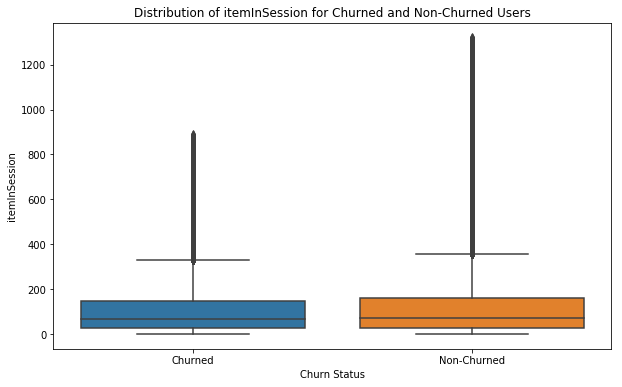

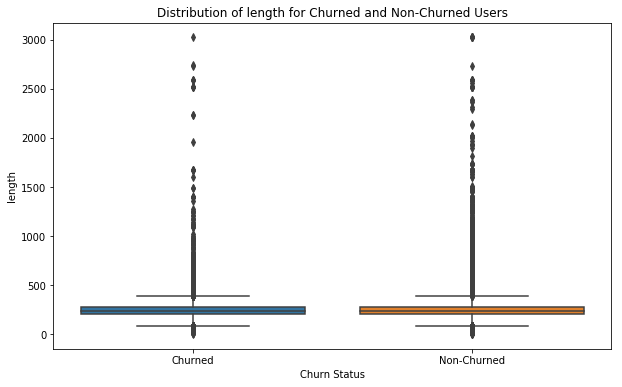

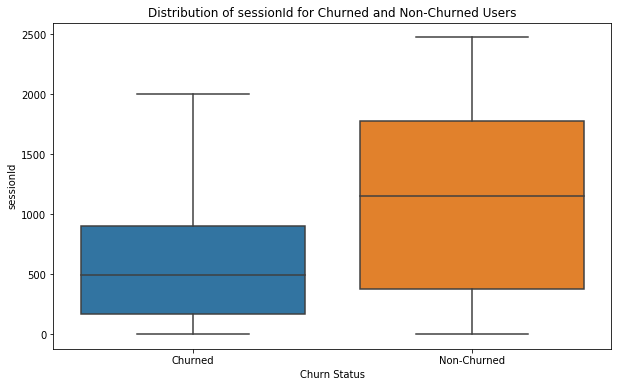

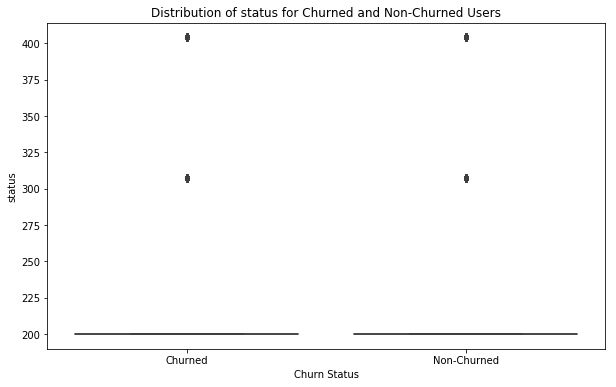

In [57]:
# Fetch data for churned and non-churned users
churn = spark.sql('''
    SELECT itemInSession, length, sessionId, status 
    FROM Sparkify_cleaned_View
    WHERE Churn == 1
''').toPandas()

nochurn = spark.sql('''
    SELECT itemInSession, length, sessionId, status 
    FROM Sparkify_cleaned_View
    WHERE Churn == 0
''').toPandas()

# Create combined DataFrame for boxplot
churn['Churn'] = 'Churned'
nochurn['Churn'] = 'Non-Churned'
combined_data = pd.concat([churn, nochurn])

# Draw boxplot for itemInSession
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x='Churn', y='itemInSession')
plt.title('Distribution of itemInSession for Churned and Non-Churned Users')
plt.xlabel('Churn Status')
plt.ylabel('itemInSession')
plt.show()

# Draw boxplot for length
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x='Churn', y='length')
plt.title('Distribution of length for Churned and Non-Churned Users')
plt.xlabel('Churn Status')
plt.ylabel('length')
plt.show()

# Draw boxplot for sessionId
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x='Churn', y='sessionId')
plt.title('Distribution of sessionId for Churned and Non-Churned Users')
plt.xlabel('Churn Status')
plt.ylabel('sessionId')
plt.show()

# Draw boxplot for status
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x='Churn', y='status')
plt.title('Distribution of status for Churned and Non-Churned Users')
plt.xlabel('Churn Status')
plt.ylabel('status')
plt.show()

### Auth
Let's check the Auth variable

In [58]:
sparkify_df_flg.dropDuplicates(["userId"]).groupby(["Churn", "auth"]).count().sort("Churn").show()

+-----+---------+-----+
|Churn|     auth|count|
+-----+---------+-----+
|    0|Logged In|  173|
|    1|Logged In|   52|
+-----+---------+-----+



In [59]:
# This step is to update temporary view
sparkify_df_flg.createOrReplaceTempView("Sparkify_cleaned_View")

### Gender
Let's check the Gender variable

In [60]:
spark.sql('''
          SELECT Churn, gender, COUNT(DISTINCT userId) AS No_of_Users
          FROM Sparkify_cleaned_View 
          GROUP BY Churn, gender
          ORDER BY Churn DESC, gender
          '''
         ).show()

+-----+------+-----------+
|Churn|gender|No_of_Users|
+-----+------+-----------+
|    1|     F|         20|
|    1|     M|         32|
|    0|     F|         84|
|    0|     M|         89|
+-----+------+-----------+



### Length
Let's check the Length variable

In [61]:
spark.sql('''
SELECT Churn,
           AVG(length) AS average_length,
           MIN(length) AS minimum_length,
           MAX(length) AS maximum_length
    FROM Sparkify_cleaned_View
    GROUP BY Churn
    ORDER BY Churn DESC
          '''
         ).show()

+-----+------------------+--------------+--------------+
|Churn|    average_length|minimum_length|maximum_length|
+-----+------------------+--------------+--------------+
|    1|248.63279564406218|       4.04853|    3024.66567|
|    0|249.20913538880816|       0.78322|    3024.66567|
+-----+------------------+--------------+--------------+



### Level
Let's check the Level variable

In [62]:
spark.sql('''
        SELECT Churn, level,COUNT(DISTINCT userId) AS No_of_Users
        FROM Sparkify_cleaned_View
        GROUP BY Churn, level
        ORDER BY No_of_Users DESC
''').show()

+-----+-----+-----------+
|Churn|level|No_of_Users|
+-----+-----+-----------+
|    0| free|        149|
|    0| paid|        129|
|    1| free|         46|
|    1| paid|         36|
+-----+-----+-----------+



### Method
Let's check the method variable

In [63]:
spark.sql('''
        SELECT Churn, method,COUNT(userId) AS No_of_users
        FROM Sparkify_cleaned_View
        GROUP BY method, Churn
        ORDER BY No_of_users DESC
''').show()

+-----+------+-----------+
|Churn|method|No_of_users|
+-----+------+-----------+
|    0|   PUT|     216691|
|    1|   PUT|      41127|
|    0|   GET|      16599|
|    1|   GET|       3737|
+-----+------+-----------+



### Artist

In [64]:
# Query to find the most played artist among non-churned users
artist_non_churn_user = spark.sql('''
    SELECT Artist, COUNT(Artist) AS users 
    FROM Sparkify_cleaned_View 
    WHERE Churn = 0
    GROUP BY Artist
    ORDER BY users DESC 
''').toPandas()

In [65]:
# Query to find the most played artist among churned users
artist_churn_user = spark.sql('''
    SELECT Artist, COUNT(Artist) AS users 
    FROM Sparkify_cleaned_View 
    WHERE Churn = 1
    GROUP BY Artist 
    ORDER BY users DESC 
''').toPandas()

In [66]:
# Merge the two DataFrames
df_artist = artist_non_churn_user.merge(artist_churn_user, on='Artist', how='outer', suffixes=('_active', '_churn'))

In [67]:
df_artist.head(10)

,Artist,users_active,users_churn
0,Coldplay,1552.0,261.0
1,Kings Of Leon,1542.0,299.0
2,Florence + The Machine,1048.0,188.0
3,BjÃÂ¶rk,962.0,171.0
4,Dwight Yoakam,952.0,183.0
5,The Black Keys,940.0,185.0
6,Muse,926.0,164.0
7,Justin Bieber,876.0,168.0
8,Jack Johnson,852.0,155.0
9,Eminem,805.0,148.0


In [68]:
# This step is to calculate the total number of plays
df_artist['tot_plays'] = df_artist['users_active'].fillna(0) + df_artist['users_churn'].fillna(0)

In [69]:
df_artist = df_artist.nlargest(10, 'tot_plays')

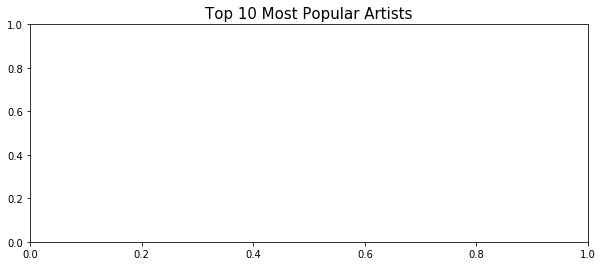

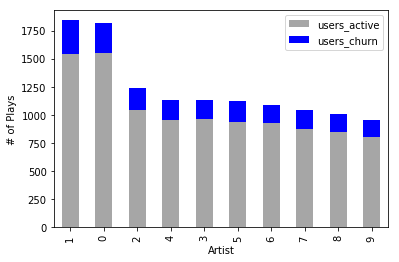

In [70]:
# This srep is to draw plot
plt.figure(figsize=(10, 4))
plt.title('Top 10 Most Popular Artists', fontsize=15)
df_artist[['users_active', 'users_churn']].plot(kind='bar', stacked=True, color=['0.65', 'b'], legend=True)
plt.xlabel("Artist", fontsize=10)
plt.ylabel("# of Plays", fontsize=10)
plt.show()

### location

In [71]:
spark.sql('''
        SELECT location, Churn, COUNT(DISTINCT userId) AS No_of_Users
        FROM Sparkify_cleaned_View
        GROUP BY location, Churn
        ORDER BY No_of_Users DESC
''').show()

+--------------------+-----+-----------+
|            location|Churn|No_of_Users|
+--------------------+-----+-----------+
|Los Angeles-Long ...|    0|         13|
|New York-Newark-J...|    0|         10|
|Charlotte-Concord...|    0|          6|
|Dallas-Fort Worth...|    0|          6|
|Chicago-Napervill...|    0|          5|
|    St. Louis, MO-IL|    0|          5|
|Boston-Cambridge-...|    0|          5|
|New York-Newark-J...|    1|          5|
|Phoenix-Mesa-Scot...|    0|          5|
|Atlanta-Sandy Spr...|    0|          4|
|Philadelphia-Camd...|    0|          3|
|Houston-The Woodl...|    0|          3|
|Las Vegas-Henders...|    0|          3|
|Washington-Arling...|    0|          3|
|New Haven-Milford...|    0|          3|
|Miami-Fort Lauder...|    0|          3|
|Los Angeles-Long ...|    1|          3|
|     Tallahassee, FL|    0|          2|
|San Antonio-New B...|    0|          2|
|Providence-Warwic...|    0|          2|
+--------------------+-----+-----------+
only showing top

In [72]:
# This step is to split the 'location' column into two columns from comma between two strings.
sparkify_df_flg = sparkify_df_flg.withColumn('city', split(sparkify_df_flg['location'], ",").getItem(0))\
        .withColumn('state', split(sparkify_df_flg['location'], ",").getItem(1))

In [73]:
# This step is to update temporary view
sparkify_df_flg.createOrReplaceTempView("Sparkify_cleaned_View")

In [74]:
spark.sql('''
        SELECT city, Churn, COUNT(DISTINCT userId) AS No_of_Users
        FROM Sparkify_cleaned_View
        GROUP BY city, Churn
        ORDER BY Churn DESC
''').show(10)

+--------------------+-----+-----------+
|                city|Churn|No_of_Users|
+--------------------+-----+-----------+
|Dallas-Fort Worth...|    1|          1|
|Miami-Fort Lauder...|    1|          2|
|Greenville-Anders...|    1|          1|
|             Memphis|    1|          1|
|             Bozeman|    1|          1|
|Spokane-Spokane V...|    1|          2|
|Chicago-Napervill...|    1|          1|
|Los Angeles-Long ...|    1|          3|
|   Birmingham-Hoover|    1|          1|
|Washington-Arling...|    1|          1|
+--------------------+-----+-----------+
only showing top 10 rows



In [75]:
spark.sql('''
        SELECT state, Churn, COUNT(DISTINCT userId) AS No_of_Users
        FROM Sparkify_cleaned_View
        GROUP BY state, Churn
        ORDER BY Churn DESC
''').show(10)

+-----+-----+-----------+
|state|Churn|No_of_Users|
+-----+-----+-----------+
|   CO|    1|          2|
|   AL|    1|          2|
|   CA|    1|          6|
|   WA|    1|          2|
|   LA|    1|          1|
|   MS|    1|          2|
|   FL|    1|          3|
|   IN|    1|          1|
|   AR|    1|          1|
|   KY|    1|          2|
+-----+-----+-----------+
only showing top 10 rows



In [76]:
# This step is to find the churn state among churned users
loc_non_churn_user = spark.sql('''
    SELECT state, COUNT(DISTINCT userId) AS active_users 
    FROM Sparkify_cleaned_View 
        WHERE Churn = 0
        GROUP BY state
        ORDER BY active_users DESC
''').toPandas()

In [77]:
# This step is to find the churn state among churned users
loc_churn_user = spark.sql('''
    SELECT state, COUNT(DISTINCT userId) AS churn_users 
    FROM Sparkify_cleaned_View 
        WHERE Churn = 1
        GROUP BY state
        ORDER BY churn_users DESC
''').toPandas()

In [78]:
loc_state = pd.concat([loc_churn_user.groupby('state').sum(), loc_non_churn_user.groupby('state').sum()], \
                              axis=1, join="outer", sort=True)

In [79]:
loc_state = loc_state.sort_values(by=['active_users', 'churn_users'], ascending=False)

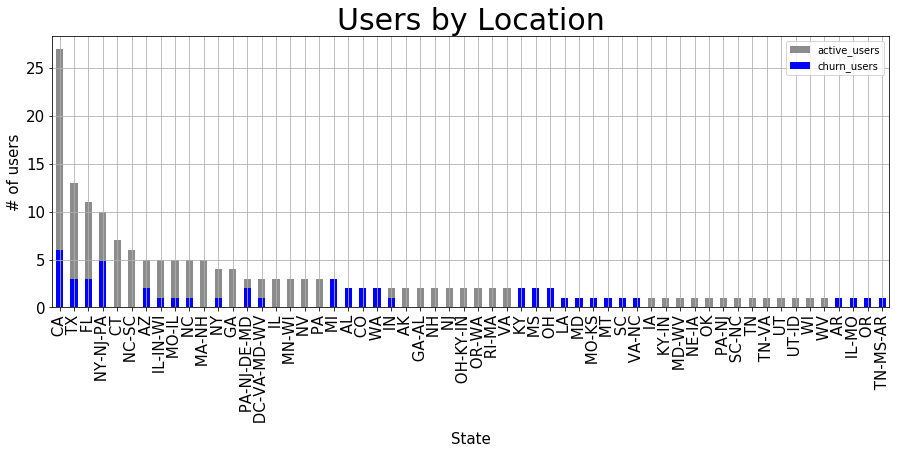

In [80]:
plt.title('Users by Location', fontsize=30)

ax = loc_state['active_users'].plot(kind='bar', \
                                               color ='0.55', figsize=(15, 5), legend=True, fontsize=15)

ax = loc_state['churn_users'].plot(kind='bar', \
                                              color ='b', legend=True, fontsize=15)
ax.set_xlabel("State", fontsize=15)
ax.set_ylabel("# of users", fontsize=15)
plt.grid(True)
plt.show()

### Page

In [81]:
spark.sql('''
    SELECT page, 
           CASE WHEN Churn = 1 THEN 'Churned' ELSE 'Active' END AS Churn_Status,
           COUNT(DISTINCT userId) AS Total_Users
    FROM Sparkify_cleaned_View 
    GROUP BY page, Churn_Status
    ORDER BY total_users DESC
''').show()

+--------------------+------------+-----------+
|                page|Churn_Status|Total_Users|
+--------------------+------------+-----------+
|            NextSong|      Active|        173|
|                Home|      Active|        172|
|           Thumbs Up|      Active|        170|
|              Logout|      Active|        167|
|     Add to Playlist|      Active|        165|
|          Add Friend|      Active|        162|
|         Roll Advert|      Active|        157|
|         Thumbs Down|      Active|        155|
|            Settings|      Active|        152|
|                Help|      Active|        149|
|             Upgrade|      Active|        131|
|               About|      Active|        124|
|           Downgrade|      Active|        119|
|       Save Settings|      Active|        102|
|      Submit Upgrade|      Active|        102|
|               Error|      Active|         95|
|Cancellation Conf...|     Churned|         52|
|              Cancel|     Churned|     

NextSong, Home, Thumbs Up, Logout, Add to Playlist seems most visited pages by active Users.

### UserAgent

In [82]:
#This step is to get the UserAgent by chrurn status and user count
spark.sql('''
    SELECT useragent, 
           CASE WHEN Churn = 1 THEN 'Churned' ELSE 'Active' END AS Churn_Status,
           COUNT(DISTINCT userId) AS Total_Users
    FROM Sparkify_cleaned_View 
    GROUP BY useragent, Churn_Status
    ORDER BY useragent DESC
''').show()


+--------------------+------------+-----------+
|           useragent|Churn_Status|Total_Users|
+--------------------+------------+-----------+
|Mozilla/5.0 (comp...|      Active|          3|
|Mozilla/5.0 (comp...|      Active|          1|
|Mozilla/5.0 (comp...|      Active|          1|
|Mozilla/5.0 (X11;...|     Churned|          3|
|Mozilla/5.0 (X11;...|      Active|          1|
|Mozilla/5.0 (X11;...|     Churned|          1|
|Mozilla/5.0 (X11;...|      Active|          1|
|Mozilla/5.0 (Wind...|      Active|          3|
|Mozilla/5.0 (Wind...|     Churned|          1|
|Mozilla/5.0 (Wind...|     Churned|          1|
|Mozilla/5.0 (Wind...|     Churned|          1|
|Mozilla/5.0 (Wind...|      Active|          2|
|Mozilla/5.0 (Wind...|      Active|          1|
|Mozilla/5.0 (Wind...|     Churned|          1|
|Mozilla/5.0 (Wind...|      Active|         14|
|Mozilla/5.0 (Wind...|     Churned|          4|
|Mozilla/5.0 (Wind...|      Active|          1|
|Mozilla/5.0 (Wind...|     Churned|     

### Status

In [83]:
spark.sql('''
    SELECT status, 
           CASE WHEN Churn = 1 THEN 'Churned' ELSE 'Active' END AS Churn_Status,
           COUNT(DISTINCT userId) AS Total_Users
    FROM Sparkify_cleaned_View 
    GROUP BY status, Churn_Status
    ORDER BY status DESC
''').show()


+------+------------+-----------+
|status|Churn_Status|Total_Users|
+------+------------+-----------+
|   404|      Active|         95|
|   404|     Churned|         22|
|   307|     Churned|         52|
|   307|      Active|        171|
|   200|     Churned|         52|
|   200|      Active|        173|
+------+------------+-----------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

The following variables show substantial discrepancies between churned and active users, suggesting their potential ignificance in predicting customer churn:

- Number of songs played per user
- Count of 'Thumbs Up' page interactions per user
- Count of 'Thumbs Down' page interactions per user
- Count of 'Add to Playlist' page interactions per user
- Count of 'Add Friend' page interactions per user
- Count of 'Error' per user
- Count of 'length' of songs listened per user
- Number of sessions per user
- Count of 'status' per user
- Count of 'level' per user
- Gender

We'll create additional columns into the dataset to do a more thorough analysis of their predictive potential.

In [84]:
sparkify_df_flg.show()

+------+--------------------+---------+------+-------------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+-------------------+------------------------+----------------------+-----+---------------+------------------+--------------------+-----+
|userId|              artist|     auth|gender|itemInSession|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|        dateandtime|registration_dateandtime|days_from_registration|churn|downgrade_click|total_downgrad_clk|                city|state|
+------+--------------------+---------+------+-------------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+-------------------+------------------------+----------------------+-----+---------------+------------------+--------

In [85]:
from pyspark.sql.functions import when, col, countDistinct, sum as spark_sum

# Apply feature engineering on variables
features_df = sparkify_df_flg.groupBy("userId").agg(
    spark_sum(when(col("gender") == "F", 1).otherwise(0)).alias("f_user"),
    spark_sum(when(col("gender") == "M", 1).otherwise(0)).alias("m_user"),
    countDistinct(when(col("song").isNotNull(), col("song"))).alias("tot_songs_played"),
    spark_sum(when(col("page") == "Thumbs Up", 1).otherwise(0)).alias("tot_thumbs_up"),
    spark_sum(when(col("page") == "Thumbs Down", 1).otherwise(0)).alias("tot_thumbs_down"),
    spark_sum(when(col("page") == "Add to Playlist", 1).otherwise(0)).alias("tot_playlist_adds"),
    spark_sum(when(col("page") == "Add Friend", 1).otherwise(0)).alias("tot_friends_added"),
    spark_sum(when(col("page") == "Error", 1).otherwise(0)).alias("tot_errors"),
    spark_sum(when(col("page") == "Help", 1).otherwise(0)).alias("tot_help_request"),
    spark_sum(when(col("length").isNotNull(), col("length"))).alias("tot_length"),
    countDistinct(col("dateandtime")).alias("tot_sessions"),
    spark_sum(when(col("status") == 404, 1).otherwise(0)).alias("tot_404_errors"),
    spark_sum(when(col("level") == "paid", 1).otherwise(0)).alias("paid_user")
)

# Join features with the main dataframe
sparkify_df_flg = sparkify_df_flg.join(features_df, on="userId", how="left")

# Fill NaN values with 0 for features
features = ["f_user", "m_user", 
            "tot_songs_played", 
            "tot_thumbs_up", "tot_thumbs_down",
            "tot_playlist_adds", "tot_friends_added", "tot_errors", "tot_help_request",
            "tot_length", "tot_sessions", "tot_404_errors", "paid_user"]
sparkify_df_flg = sparkify_df_flg.fillna(0, subset=features)

# Drop redundant or unnecessary columns
drop_cols = ['registration', 'userAgent', 'location', 'ts'] 
sparkify_df_flg = sparkify_df_flg.drop(*drop_cols)


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Creating Logistic Regression Model

In [86]:
assembler = VectorAssembler(inputCols=["f_user", "m_user", "tot_songs_played", "tot_thumbs_up", "tot_thumbs_down",
            "tot_playlist_adds", "tot_friends_added", "tot_errors","tot_help_request",
            "tot_length", "tot_sessions", "tot_404_errors",
            "paid_user"], 
                            outputCol="features")

classifier = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0.0, labelCol="churn")
pipeline = Pipeline(stages=[assembler, classifier])

train, test = sparkify_df_flg.randomSplit([0.8, 0.2], seed=45)

model = pipeline.fit(train)
predictions = model.transform(test)

evaluator_for_f1 = MulticlassClassificationEvaluator(labelCol="churn", metricName='f1')
score_of_f1 = evaluator_for_f1.evaluate(predictions)
print("F1 Score:", score_of_f1)

evaluator_for_auc = BinaryClassificationEvaluator(labelCol="churn", metricName='areaUnderROC')
score_of_auc = evaluator_for_auc.evaluate(predictions)
print("AUC Score:", score_of_auc)

F1 Score: 0.7844468769407186
AUC Score: 0.7767963831727738


### Creating Support Vector Machine Model

In [87]:
assembler = VectorAssembler(inputCols=["f_user", "m_user", "tot_songs_played", "tot_thumbs_up", "tot_thumbs_down",
            "tot_playlist_adds", "tot_friends_added", "tot_errors","tot_help_request",
            "tot_length", "tot_sessions", "tot_404_errors",
            "paid_user"],
                            outputCol="features")

svm = LinearSVC(maxIter=10, regParam=0.0, labelCol="churn")

pipeline = Pipeline(stages=[assembler, svm])

train, test = sparkify_df_flg.randomSplit([0.8, 0.2], seed=45)
model = pipeline.fit(train)
predictions = model.transform(test)

evaluator_for_f1 = MulticlassClassificationEvaluator(labelCol="churn", metricName='f1')
score_of_f1 = evaluator_for_f1.evaluate(predictions)
print("F1 Score:", score_of_f1)

evaluator_for_auc = BinaryClassificationEvaluator(labelCol="churn", metricName='areaUnderROC')
score_of_auc = evaluator_for_auc.evaluate(predictions)
print("AUC Score:", score_of_auc)

F1 Score: 0.7690553807154255
AUC Score: 0.7346460272296704


### Creating Gradient Boost Classifier Model

In [88]:
assembler = VectorAssembler(inputCols=["f_user", "m_user", "tot_songs_played", "tot_thumbs_up", "tot_thumbs_down",
            "tot_playlist_adds", "tot_friends_added", "tot_errors","tot_help_request",
            "tot_length", "tot_sessions", "tot_404_errors",
            "paid_user"],
                            outputCol="features")

gbt = GBTClassifier(maxIter=10, maxDepth=5, labelCol="churn")

pipeline = Pipeline(stages=[assembler, gbt])

train, test = sparkify_df_flg.randomSplit([0.8, 0.2], seed=45)

model = pipeline.fit(train)
predictions = model.transform(test)

evaluator_for_f1 = MulticlassClassificationEvaluator(labelCol="churn", metricName='f1')
score_of_f1 = evaluator_for_f1.evaluate(predictions)
print("F1 Score:", score_of_f1)

evaluator_for_auc = BinaryClassificationEvaluator(labelCol="churn", metricName='areaUnderROC')
score_of_auc = evaluator_for_auc.evaluate(predictions)
print("AUC Score:", score_of_auc)

F1 Score: 0.9733338852798261
AUC Score: 0.9992440779015909


To evaluate the effectiveness of each model, I've employed two common metrics: the F1 score and the Area under the Curve (AUC). The F1 score provides a balance between precision and recall, making it suitable for imbalanced datasets or situations where both false positives and false negatives are equally important. The AUC metric measures the ability of the model to discriminate between positive and negative classes, with a higher AUC indicating better performance.

After running the Logistic Regression, SVM (Support Vector Machine) and Gradient Boost Model, here are the F1 scores for these:

Score for logistic regression model:
F1 Score: 0.7844468769407186
AUC Score: 0.7767963831727738

Score for Support Vector Machine:
F1 Score: 0.7690553807154255
AUC Score: 0.7346460272296704

Score for Gradient Boost Classifier:
F1 Score: 0.9733338852798261
AUC Score: 0.9992440779015909

From the scores, the gradient boost classifier is the top-performing model among the three models. For further analysis, 
we can do more work on feature enginerring and can also tune model to further increase performance.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.